In [61]:
import sys
import os
import torch

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB and not "dida_test" in os.listdir(os.getcwd()):
  !git clone https://github.com/michelj5/dida_test

DATA_PATH = os.path.join(os.getcwd(), 'dida_test', 'data') if IN_COLAB else os.path.join(os.getcwd(), 'data')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [62]:
import torch
x = torch.rand(3,5)
print(x)

tensor([[0.5509, 0.1487, 0.7811, 0.8412, 0.3960],
        [0.5264, 0.3004, 0.8855, 0.2659, 0.9238],
        [0.1967, 0.5709, 0.3381, 0.0911, 0.4640]])


In [70]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class LocalImageDataset(Dataset):
    def __init__(self, root_dir, test=False, transform=None, target_transform=None):
        self.test = test
        self.root_dir = root_dir

        # Assume that the images missing labels are the last 5 (this is the case for the given data)
        self.image_names = sorted(os.listdir(os.path.join(root_dir, 'images')))
        self.label_names = sorted(os.listdir(os.path.join(root_dir, 'labels')))

        if not self.test:
            self.image_names = [name  for name in self.image_names if name in self.label_names]
        else:
            self.image_names = [name  for name in self.image_names if name not in self.label_names]
            self.label_names = []

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.label_names)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, 'images', self.image_names[idx])
        image = Image.open(image_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label = None
        if not self.test:
            label_name = os.path.join(self.root_dir, 'labels', self.label_names[idx])
            label = Image.open(label_name).convert("L")
            if self.target_transform:
                label = self.target_transform(label)


        return image, label

In [79]:
from torchvision import transforms
from torch.utils.data import DataLoader

train_dataset = LocalImageDataset(DATA_PATH,
                            transform=transforms.ToTensor(),
                            target_transform=transforms.ToTensor()
)
train_dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

test_dataset = LocalImageDataset(DATA_PATH,transform=None,test=True)
# Never trust 5 * 5 = 25
# for (img, label) in dataloader:
#   print(img.size())
#   print(label.size())

# for (img, label) in LocalImageDataset(DATA_PATH, transform = transforms.ToTensor(), test=True):
#     print(type(img), type(label))

In [73]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3,1,1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_channels, out_channels, 3,1,1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self,x):
    return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512]):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # print("===== DOWN ====")
        for down in self.downs:
            x = down(x)
            # print(x.size())
            skip_connections.append(x)
            x = self.pool(x)
            # print(x.size())
            # print()

        # print("===== BOTTLENECK ====")
        x = self.bottleneck(x)
        # print(x.size())
        # print()
        skip_connections = skip_connections[::-1]

        # print("===== UP ====")
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            # print(x.size())
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(
                    x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True
                )

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            # print(x.size())
            # print()

        # print("==== FINAL ====")
        x = self.final_conv(x)
        # print(x.size())
        # print()
        return x


In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Initialize model
model = UNet().to(device)

# Loss function, optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 20
for epoch in range(num_epochs):
    loop = tqdm(dataloader, total=len(dataloader), leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

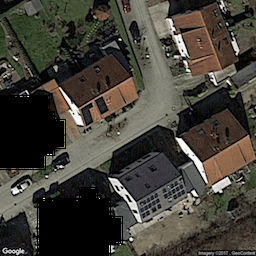

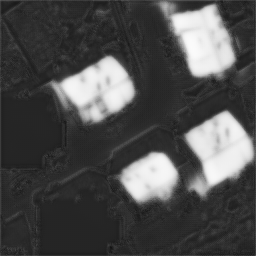

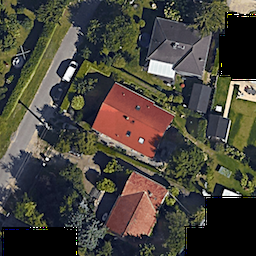

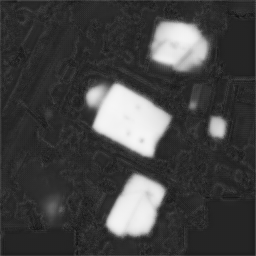

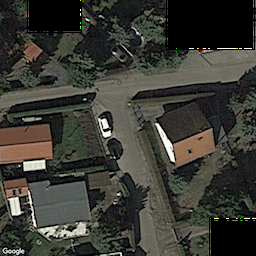

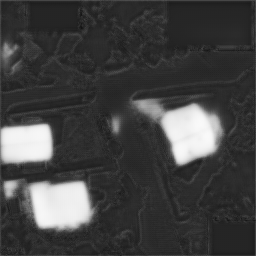

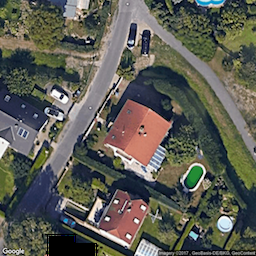

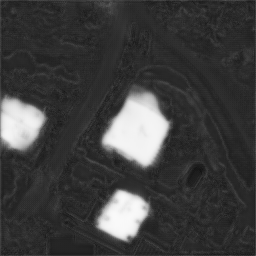

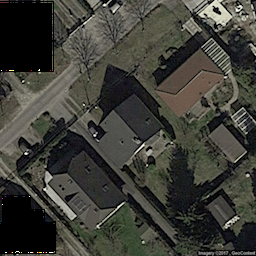

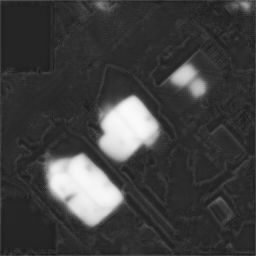

In [87]:
import torch
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import matplotlib.pyplot as plt

to_tensor = ToTensor()
to_image = ToPILImage()

model.eval()

for (image, _) in test_dataset:
    display(image)
    image = to_tensor(image).unsqueeze(0).to(device)
    output = model(image)
    output = torch.sigmoid(output)
    output = output.squeeze()
    output = to_image(output)
    display(output)